# Comparing the Proportion of Violent Crimes Between Two Neighbourhoods in Vancouver

# Introduction

From the news and government reports, the total number of violent crimes increases over recent years. Compared to pre-pandemic levels, violent crime increased by 12 percent in the Vancouver area (Penny Daflos, 2023).

This project attempts to investigate more about violent crimes in Vancouver, Canada. The dataset used is taken from the Vancouver Police Department from the years 2022 to 2023 of the neighbourhoods Hastings-Sunrise and West Point Grey (Official Website of the Vancouver Police Department, 2023). These neighbourhoods were chosen as West Point Grey is towards the west of Vancouver and the other is towards the east and neighbourhoods too close may yield similar results.

We want to answer the following question:

**Is there a significant difference between the proportion of violent crimes (homicides and offences against another person) within the past two years between two different neighbourhoods, specifically, Hastings-Sunrise and West Point Grey?**


The columns in this dataset contain the following columns:
1. ``Type``: of crime
2. ``Year``
3. ``Month``
4. ``Day``
5. ``Hour``
6. ``Minute``
7. ``Hundred_Block`` (generalized location of the crime)
8. ``Neighbourhood``
9. ``X``: coordinate
10. ``Y``: coordinate

The type of crimes recorded includes:
1. ``BNE Commercial``: (Commercial Break and Enter)
2. ``BNE Residential/Other``
3. ``Vehicle Collision or Pedestrian Struck (with Fatality)``
4. ``Vehicle Collision or Pedestrian Struck (with Injury)``
5. ``Homicide``
6. ``Mischief``
7. ``Offence Against a Person``
8. ``Other Theft``
9. ``Theft from Vehicle``
10. ``Theft of Vehicle``
11. ``Theft of Bicycle``

# Methods and Results

## Required Packages

In [1]:
library(tidyverse)
library(base)
library(dplyr)
library(infer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## Reading data from the web

In [2]:
hastings_2023 <- read_csv("https://raw.githubusercontent.com/Carson-Lu/stat201project-Group27/main/crimedata_csv_Hastings-Sunrise_2023.csv")
hastings_2022 <- read_csv("https://raw.githubusercontent.com/Carson-Lu/stat201project-Group27/main/crimedata_csv_Hastings-Sunrise_2022.csv")
west_point_grey_2022 <- read_csv("https://raw.githubusercontent.com/Carson-Lu/stat201project-Group27/main/crimedata_csv_West%20Point%20Grey_2022.csv")
west_point_grey_2023 <- read_csv("https://raw.githubusercontent.com/Carson-Lu/stat201project-Group27/main/crimedata_csv_West%20Point%20Grey_2023.csv")

Rows: 482 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): TYPE, HUNDRED_BLOCK, NEIGHBOURHOOD
dbl (7): YEAR, MONTH, DAY, HOUR, MINUTE, X, Y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 946 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): TYPE, HUNDRED_BLOCK, NEIGHBOURHOOD
dbl (7): YEAR, MONTH, DAY, HOUR, MINUTE, X, Y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 238 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): TYPE, HUNDRED_BLOCK, NEIGHBOURHOOD
dbl (7): YEAR, MONTH, DAY, HOUR, MINUTE, X, Y

ℹ Use `spec()` to retrieve the full column specification for this

## Data cleaning and wrangling

## Combining all the datasets into one

In [3]:
crimes <- rbind(hastings_2022, hastings_2023, west_point_grey_2022, west_point_grey_2023)
head(crimes)

TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Theft from Vehicle,2022,5,16,4,20,11XX NOOTKA ST,Hastings-Sunrise,496992.1,5457928
Theft from Vehicle,2022,10,9,2,0,11XX ROSSLAND ST,Hastings-Sunrise,496691.3,5457991
Theft from Vehicle,2022,4,28,17,0,12XX LILLOOET ST,Hastings-Sunrise,497174.1,5457852
Theft from Vehicle,2022,4,17,5,17,12XX ROSSLAND ST,Hastings-Sunrise,496689.9,5457876
Theft from Vehicle,2022,11,8,22,0,12XX SKEENA ST,Hastings-Sunrise,497929.5,5457926
Theft from Vehicle,2022,8,18,20,46,13XX KAMLOOPS ST,Hastings-Sunrise,496017.2,5457788


Table 1: combined crimes dataset

##  Cleaning the dataset

Checking if there are any missing values (TYPE is NA)

In [4]:
num_na <- crimes |>
    filter(is.na(TYPE)) |>
    nrow()
cat("There are", num_na, "missing values in our sample")

There are 0 missing values in our sample

In [5]:
# removing unwanted columns from the dataset
crimes_cleaned <- crimes |> 
    select(TYPE, YEAR, MONTH, DAY, NEIGHBOURHOOD)

cat("Number of entries in our dataset:", nrow(crimes_cleaned))

# Checking the max day in July 2023
entries_july <- crimes_cleaned |> 
    filter(YEAR == 2023 & MONTH == 7) |>
    select(DAY) |>
    pull() |>
    max()

cat("\nWe have", entries_july, "entries in July meaning that not all crimes in July have been reported yet so we will be removing the month July 2023")

Number of entries in our dataset: 1831
We have 19 entries in July meaning that not all crimes in July have been reported yet so we will be removing the month July 2023

Removing July 2023 from our dataset since data from the month is not complete

In [6]:
# Since the most recent date in July was the 19th, it is probably not complete so we can leave that out 
crimes_cleaned <- crimes_cleaned |>
    filter(YEAR != 2023 | MONTH != 7)

For simplicity, we will convert the crimes in our dataset into two types, "violent" and "non violent" 

In [7]:
# Grouping "Homicide" and "Offence Against a Person" as the same type
crimes_cleaned$TYPE <- replace(crimes_cleaned$TYPE, crimes_cleaned$TYPE == "Homicide", "Violent Crime")
crimes_cleaned$TYPE <- replace(crimes_cleaned$TYPE, crimes_cleaned$TYPE == "Offence Against a Person", "Violent Crime")

# Grouping all other crimes as "non-violent" crimes
crimes_cleaned$TYPE <- replace(crimes_cleaned$TYPE, crimes_cleaned$TYPE != "Violent Crime", "Non Violent Crime")

head(crimes_cleaned)

TYPE,YEAR,MONTH,DAY,NEIGHBOURHOOD
<chr>,<dbl>,<dbl>,<dbl>,<chr>
Non Violent Crime,2022,5,16,Hastings-Sunrise
Non Violent Crime,2022,10,9,Hastings-Sunrise
Non Violent Crime,2022,4,28,Hastings-Sunrise
Non Violent Crime,2022,4,17,Hastings-Sunrise
Non Violent Crime,2022,11,8,Hastings-Sunrise
Non Violent Crime,2022,8,18,Hastings-Sunrise


Table 2: Cleaned crimes dataset

## Plots

### Plot for proportions

Here we are plotting the frequency of non-violent and violent crimes against each other so have have a better understanding of the proportion of violent crimes in Hastings-Sunrise and West Point Grey. We will also colour the plot by each neighbourhood so we can see how the number of crimes differ from the two neighbourhoods.

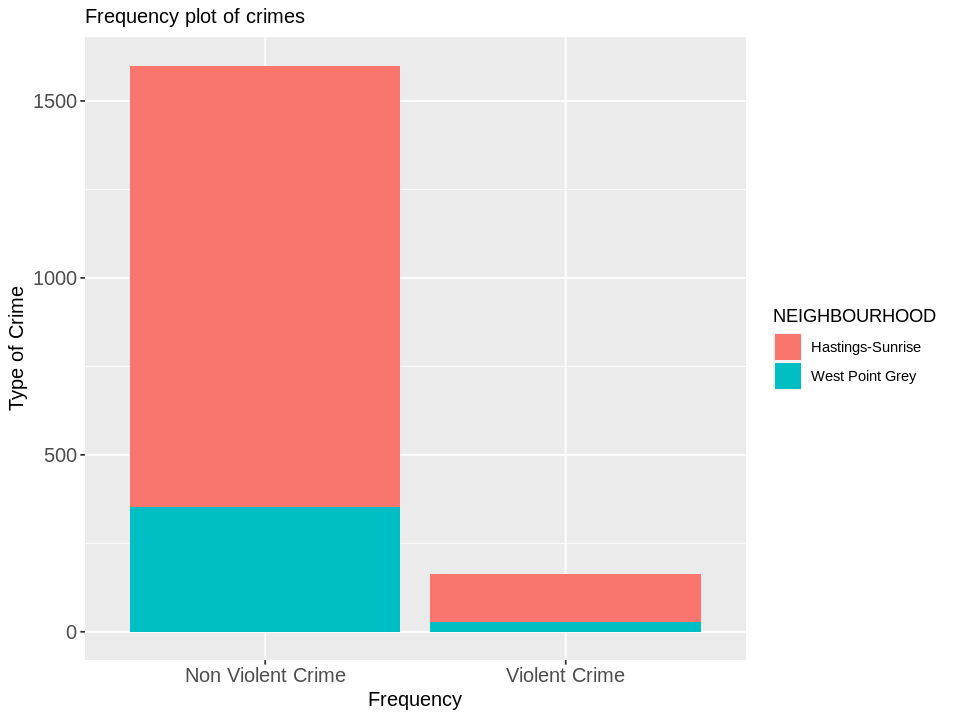

In [8]:
# Adjusting plot sizes
options(repr.plot.width=8, repr.plot.height=6)

# Plotting to see the difference between violent and non violent crimes
crimes_cleaned |>
    ggplot(aes(x = TYPE, fill = NEIGHBOURHOOD)) +
    geom_bar() +
    ggtitle("Frequency plot of crimes") +
    xlab("Frequency") +
    ylab("Type of Crime") +
    theme(axis.title = element_text(size = 12),
        axis.text = element_text(size = 12),
        plot.title = element_text(size = 12))

Plot 1: Frequency plot of crimes

Plot 1 presents a comprehensive overview of the distribution of violent and non-violent crimes in our dataset. It is evident from the plot that the majority of the recorded crimes fall under the category of non-violent offences. Moreover, when comparing both areas, it is noticeable that Hastings-Sunrise stands out as the locality with the highest number of reported crimes. 

### Plot of frequency of the frequency of Violent Crimes

Here we plot the violent crime rates of each month for 2022 and 2023 to see if there are any patterns in when the crimes occur and also to understand where they occur 

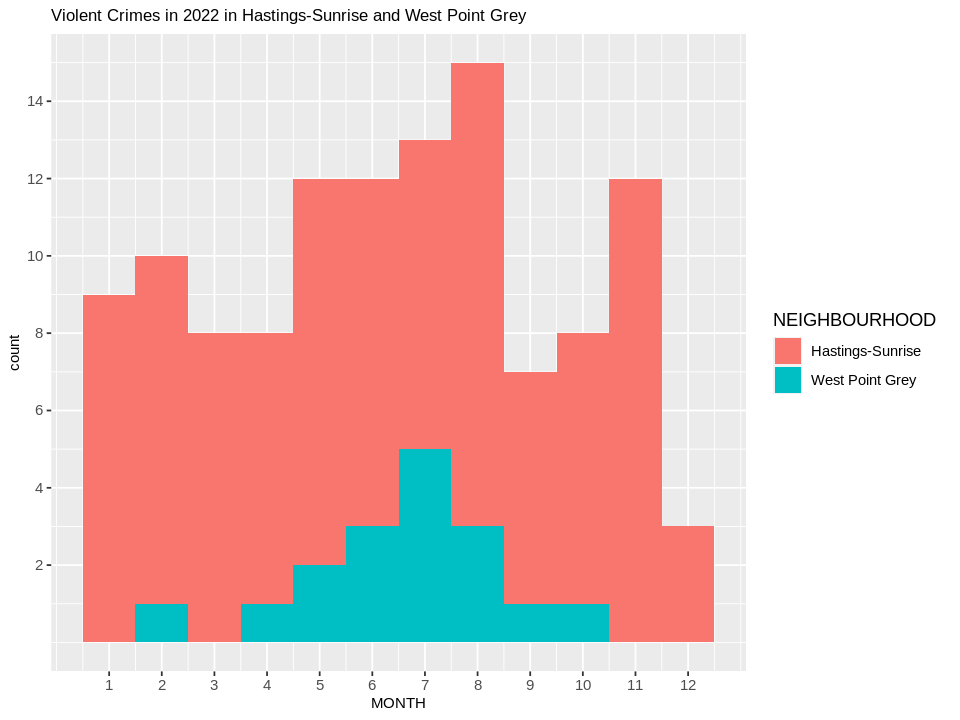

In [9]:
# Histogram of violent crimes plot in 2022
crimes_cleaned |>
    filter(TYPE == "Violent Crime") |>
    filter(YEAR == 2022) |>
    ggplot() +
    geom_histogram(aes(x = MONTH, fill = NEIGHBOURHOOD), bins = 12) + 
    ggtitle("Violent Crimes in 2022 in Hastings-Sunrise and West Point Grey") +
    scale_x_continuous(breaks = c(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)) +
    scale_y_continuous(breaks = c(2, 4, 6, 8, 10, 12, 14)) +
    theme(axis.title = element_text(size = 9),
        axis.text = element_text(size = 9),
        plot.title = element_text(size = 10)) 

Plot 2: Histogram of Violent Crimes in Hastings-Sunrise and West Point Grey 2022

In plot 2, the temporal aspect of violent crimes is explored for the year 2022, the plot illustrates that the highest number of violent crimes were recorded during the month of August. On the contrary, December exhibited the least number of reported crimes.

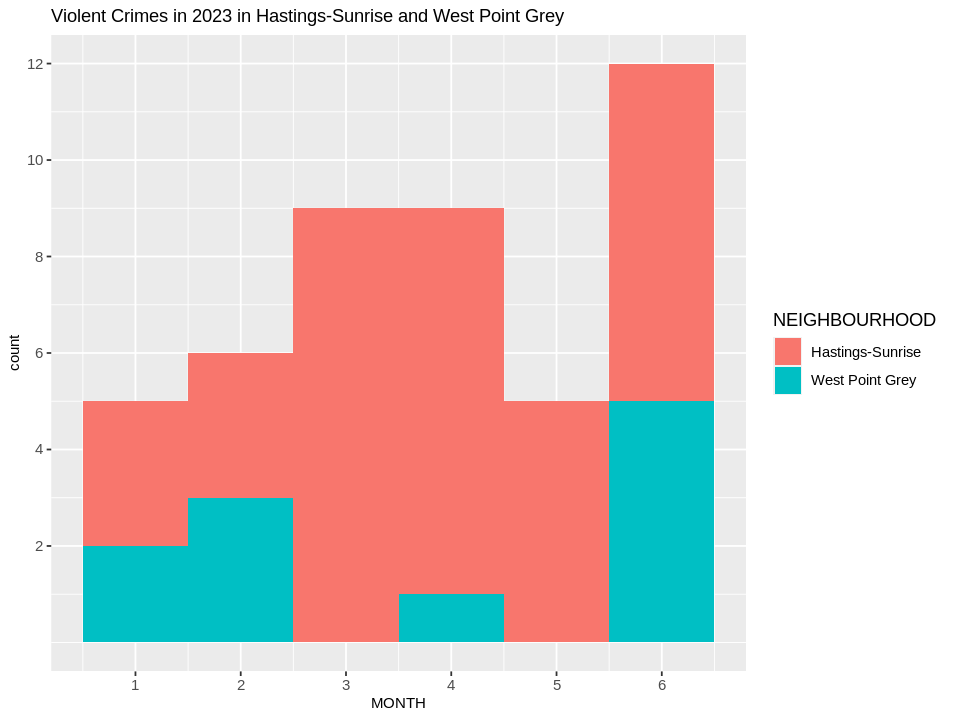

In [10]:
crimes_cleaned |>
    filter(TYPE == "Violent Crime") |>
    filter(YEAR == 2023) |>
    ggplot() +
    geom_histogram(aes(x = MONTH, fill = NEIGHBOURHOOD), bins = 6) + 
    ggtitle("Violent Crimes in 2023 in Hastings-Sunrise and West Point Grey") +
    scale_x_continuous(breaks = c(1, 2, 3, 4, 5, 6)) +
    scale_y_continuous(breaks = c(2, 4, 6, 8, 10, 12)) +
    theme(axis.title = element_text(size = 9),
        axis.text = element_text(size = 9),
        plot.title = element_text(size = 11))

Plot 3: Histogram of Violent Crimes in Hastings-Sunrise and West Point Grey 2023

Plot 3 provides an insightful view of violent crimes specifically for the first six months of the year 2023. Due to the unavailability of complete data for 2023, the analysis focuses on the trends observed during this partial period.

## Computing the average monthly crime rate of each neighbourhood

In [11]:
#filtering Offence Against a Person & Homicide crimes as they are considered violent
violent_crimes <- crimes_cleaned |> 
    filter(TYPE == "Violent Crime") 

In [12]:
# counting number of crimes per month for Hastings-Sunrise and West Point Grey
crimes_per_month_neighbourhood <- violent_crimes |> 
    group_by(YEAR, MONTH, NEIGHBOURHOOD) |> 
    summarise(count = n(), .groups = "drop")

# Number of months since July 2023 not included as it is not complete (and therefore we also have no data further on)
num_months <- 18 

avg_monthly_vcrimes_west_point_grey <- crimes_per_month_neighbourhood |>
    filter(NEIGHBOURHOOD == "West Point Grey") |>
    select(count) |>
    sum() / num_months

avg_monthly_vcrimes_west_Hastings_Sunrise <- crimes_per_month_neighbourhood |>
    filter(NEIGHBOURHOOD == "Hastings-Sunrise") |>
    select(count) |>
    sum() / num_months

cat("Average monthly violent crimes in West Point Grey from our sample: ", avg_monthly_vcrimes_west_point_grey)
cat("\nAvarege monthly violent crimes in Hastings-Sunrise from our sample: ", avg_monthly_vcrimes_west_Hastings_Sunrise)

Average monthly violent crimes in West Point Grey from our sample:  1.555556
Avarege monthly violent crimes in Hastings-Sunrise from our sample:  7.5

Results 1: Average monthly crime rate

## Computing proportion of violent crimes in each neighbourhood

In [13]:
#filtering West Point Grey neighbourhood
vcrimes_in_point_grey_count <- violent_crimes |> 
    filter(NEIGHBOURHOOD == "West Point Grey") |>
    nrow()

#filtering Hastings-Sunrise neighbourhood
vcrimes_in_hastings_count <- violent_crimes |> 
    filter(NEIGHBOURHOOD == "Hastings-Sunrise") |>
    nrow()

crimes_in_point_grey_count <- crimes_cleaned |>
    filter(NEIGHBOURHOOD == "West Point Grey") |>
    nrow()

crimes_in_hastings_count <- crimes_cleaned |>
    filter(NEIGHBOURHOOD == "Hastings-Sunrise") |>
    nrow()

prop_vcrimes_point_grey <- vcrimes_in_point_grey_count / crimes_in_point_grey_count
prop_vcrimes_hastings <- vcrimes_in_hastings_count / crimes_in_hastings_count

cat("Proportion of violent crimes in West Point Grey from our sample: ", prop_vcrimes_point_grey)
cat("\nProportion of violent crimes in Hastings-Sunrise from our sample: ", prop_vcrimes_hastings)

Proportion of violent crimes in West Point Grey from our sample:  0.07349081
Proportion of violent crimes in Hastings-Sunrise from our sample:  0.09768452

Results 2: Proportion of violent crimes from our sample

In [14]:
cat("Number of crimes in our sample from West Point Grey: ", crimes_in_point_grey_count)
cat("\nNumber of crimes in our sample from Hastings: ", crimes_in_hastings_count)

Number of crimes in our sample from West Point Grey:  381
Number of crimes in our sample from Hastings:  1382

Results 3: Number of data points in each sample

In [15]:
cat("Checking np >= 10 for our sample sizes. Also n(1-p) >= 10 is implied if the opposite is true since p < 0.5.")
cat("\n West Point Grey np: ", (crimes_in_point_grey_count * prop_vcrimes_point_grey))
cat("\n West Point Grey np: ", (crimes_in_hastings_count * prop_vcrimes_hastings))

Checking np >= 10 for our sample sizes. Also n(1-p) >= 10 is implied if the opposite is true since p < 0.5.
 West Point Grey np:  28
 West Point Grey np:  135

Results 4: CLT Sample size is large enough 

### Analysis of Parameters

**Proportions**

From our calculations, we have observed the following:

In West Point Grey, approximately 7.35% of the total crimes in the sample were classified as violent crimes.
 
In Hastings-Sunrise, approximately 9.77% of the total crimes in the sample were classified as violent crimes.

These proportions show that Hastings-Sunrise had a higher percentage of violent crimes compared to West Point Grey based on the sample data.

**Mean**

From the calculations, It is evident that the average number of monthly violent crimes in West Point Grey is approximately 1.56, while in Hastings-Sunrise, it is notably higher at approximately 7.5. This indicates that Hastings-Sunrise experiences a significantly higher rate of violent crimes compared to West Point Grey based on the sample data.


### Plan

We want to test if there is a significant difference in the proportion of violent crimes that occur in the neighbourhoods Hastings-Sunrise and West Point Grey. What we have provided above is insufficient to draw robust conclusions so to address this gap, we will be performing a hypothesis test (two-sample t-test) and providing a confidence interval (with 95% confidence) for the estimated difference in proportions. We will accomplish this with two methods, the first one being by bootstrapping our sample (as we do not have access to the entire population) to create a bootstrap distribution and then we can create a confidence interval for what the true difference of the proportion of violent crimes is. After, we can then conduct a hypothesis test to see if there is a significant difference in the violent crime rate proportions. We will also conduct a hypothesis and create a confidence interval using asymptotics, specifically the Central Limit Theorem (CLT), and then compare these results to those we obtained from bootstrapping.

Lastly, a discussion on why these methods are a good fit for testing the difference in proportions. 
Bootstrap distributions do not require any assumptions about the underlying distribution so they are a good fit here. 
For asymptotics, assumptions and conditions for CLT are satisfied, that is, we assume that this sample is randomly drawn from the population, it is extremely unlikely that our population is >10% of the total crimes so we assume independence between samples, and our sample is sufficiently large as shown in Result 4.

For our hypothesis test:

$H_0: p_{hastings} - p_{wpg} = 0$

$H_A: p_{hastings} - p_{wpg} \neq 0$

## Bootstrapping Method

Cleaning the dataset:

In [16]:
crimes_prop <- crimes_cleaned |> #removing the unnecessary columns
select(TYPE,NEIGHBOURHOOD)

Obtaining the bootstrap distribution with 10000 resamples of our original sample:

In [17]:
set.seed(1)

bootstrap_distribution <- crimes_cleaned |>
    specify(formula = TYPE ~ NEIGHBOURHOOD, success = "Violent Crime") |>
    generate(reps = 10000, type = "bootstrap") |>
    calculate(stat = "diff in props", order = c("Hastings-Sunrise", "West Point Grey"))
head(bootstrap_distribution)

replicate,stat
<int>,<dbl>
1,0.015647518
2,0.012226301
3,0.001536098
4,0.051627634
5,0.024085707
6,0.032251681


Calculating the observed difference in violent crimes:

In [18]:
obs_diff_prop <- crimes_prop %>% 
    specify(formula = TYPE ~ NEIGHBOURHOOD, success = "Violent Crime") |>
    calculate(stat = "diff in props", order = c("Hastings-Sunrise", "West Point Grey")) |>
    pull()
cat("Our observed difference in proportions between Hastings-Sunrise and West Point Grey is:", obs_diff_prop)

Our observed difference in proportions between Hastings-Sunrise and West Point Grey is: 0.0241937

Obtaining a confidence interval using our bootstrap distribution. Here we chose to use the standard error method rather than percentile as we would like to compare the confidence intervals (CI) produced by our bootstrap and our CLT CIs later on. 

In [19]:
se_ci <- bootstrap_distribution %>% 
  get_confidence_interval(level = 0.95, type = "se", 
                          point_estimate = obs_diff_prop)
se_ci

lower_ci,upper_ci
<dbl>,<dbl>
-0.006416621,0.05480402


Table 3: Bootstrap SE Confidence Interval

From Table 3 we can see that our 95% confidence interval contains our null hypothesis (difference = 0). Analysis and interpretatinos of this interval will be expanded upon in the discussion part of this report.

Plotting the confidence interval on our bootstrap distribution

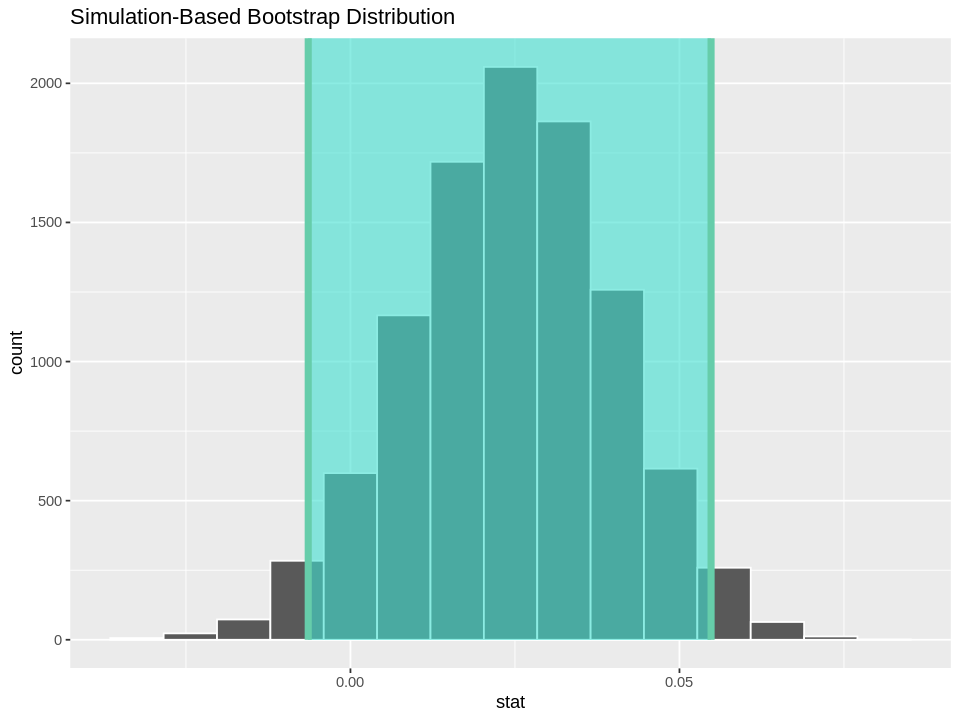

In [20]:
bootstrap_vis_se <- visualize(bootstrap_distribution) + 
  shade_confidence_interval(endpoints = se_ci) 

bootstrap_vis_se

Plot 4: Bootstrap Confidence Interval Plot

In Plot 4 we have overlayed our 95% confidence interval on our bootstrap distribution. We are 95% confident that our true mean falls within this interval and we will further discuss this in the discussion section of this report.

## CLT Method

We start by using our sample to obtain the total of the number of crime in each neighbourhood (Hastings-Sunrise and West Point Grey). Then we find the proportion of violent crimes by counting the number of crimes and dividing by the total amount of crimes for each respective neighbourhood.

In [21]:
proportions_summary <- crimes_cleaned |>
    mutate(n_crimes_hastings = sum(NEIGHBOURHOOD == "Hastings-Sunrise")) |>
    mutate(n_crimes_wpg = sum(NEIGHBOURHOOD == "West Point Grey")) |>
    filter(TYPE == "Violent Crime")  |> # Keeping only violent crimes
    mutate(prop_hastings = sum(NEIGHBOURHOOD == "Hastings-Sunrise") / n_crimes_hastings) |>
    mutate(prop_wpg = sum(NEIGHBOURHOOD == "West Point Grey") / n_crimes_wpg) |>
    select(n_crimes_hastings, n_crimes_wpg, prop_hastings, prop_wpg) |>
    head(1)

From here, we have the values required to calculate the standard error and the difference in proportions which will be used later on for calculating our confidence interval

In [22]:
proportions_summary <- proportions_summary |>
    mutate(diff_in_props = prop_hastings - prop_wpg) |>
    mutate(se = sqrt(prop_hastings*(1-prop_hastings)/n_crimes_hastings + prop_wpg * (1-prop_wpg)/n_crimes_wpg))
proportions_summary

n_crimes_hastings,n_crimes_wpg,prop_hastings,prop_wpg,diff_in_props,se
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1382,381,0.09768452,0.07349081,0.0241937,0.01557217


Table 4: Summary of values in our dataset

In table 4, we used the number of crimes and proportion of violent crimes of Hastings-Sunrise and West Point Grey to calculate the difference in proportions and the standard error of our difference. 

Now we will use the values in Table 4 to construct a 95% confidence interval.

In [23]:
confidence_interval_clt <- proportions_summary |>
    mutate(lower_ci = diff_in_props + qnorm(p = 0.025)*se, 
           upper_ci = diff_in_props + qnorm(p = 0.975)*se) |>
    select(lower_ci, upper_ci)
confidence_interval_clt

lower_ci,upper_ci
<dbl>,<dbl>
-0.006327189,0.05471459


Table 5: CLT Confidence Interval

In Table 5 we observe that our null hypothesis (there is no difference in proprtions) falls within our 95% CI for CLT, just like our bootstrap. This means that we are unable to reject the null hypothesis.

# Discussion

### Summary of findings and implications

### Is this what you expected to find? TODO



Based on data from The Vancouver Police Department (2023), we expect to see that there is a significant difference between the proportion of violent crimes in the West Point Grey neighbourhood compared to the Hasting-Sunrise neighbourhood. By comparing the proportion of violent crimes in these two areas, we can get an idea about the overall safety level between them.

### Bootstrapping vs asymptotic methods

### What future questions could this lead to?

1. What leads to the differences in violent crimes rate?
2. If there is a significant difference, why do different areas in Vancouver have this difference? 

### What impact could such findings have?

1. Residences will have a better understanding which neighbourhood is safer. By knowing the difference in violent crime rates, people can add it to consideration while deciding where to live. 
2. Policies may get benefits from our findings. Adding more resources to the area with higher violent crime rate may help reduce the number and build a safer community, 


# References

1. Andresen, M. A., & Brantingham, P. (2007, January 1). Hot spots of crime in Vancouver and their relationship with population characteristics. Www.crimrxiv.com. https://www.crimrxiv.com/pub/m7grqa2y/release/1
2. Official Website of the Vancouver Police Department. (2023). VPD OPEN DATA. Geodash.vpd.ca. https://geodash.vpd.ca/opendata/
3. Penny Daflos. (2023, February 23). 2022 saw a 12 per cent increase in violent crime in Vancouver compared to pre-pandemic levels: report. CTV NEWS. https://bc.ctvnews.ca/2022-saw-a-12-per-cent-increase-in-violent-crime-in-vancouver-compared-to-pre-pandemic-levels-report-1.6287304#:~:text=2022%20saw%20a%2012%20per
4. The Vancouver Police Department. (2023). ArcGIS Dashboards. Vancouverpolice.maps.arcgis.com. https://vancouverpolice.maps.arcgis.com/apps/dashboards/2507e3fdc79b4bfcb4994a3629866fac